In [1]:
import numpy as np;
import scipy;
import seaborn as sns;
from collections import defaultdict

In [13]:
a = np.as

In [30]:
general1 = np.random.normal(0, 1, 1000)
general2 = np.random.normal(0, 1, 1000)
general3 = np.random.normal(0, 1, 1000)


In [32]:
np.concatenate([general1, general2, general3])

array([ 1.19396609,  0.38493356, -1.1609238 , ..., -0.27399359,
        1.29372917, -0.00429534])

In [4]:
general1.std()


1.019587041059565

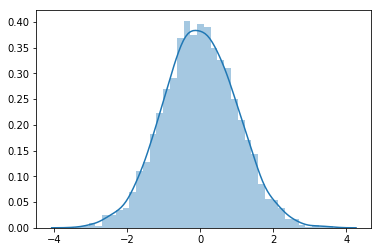

In [33]:
sns.distplot(np.concatenate([general1, general2, general3]))

In [58]:
class SamplingStrategy:
    def generate_sample(self, input, samples):
        pass
    def mexp(self):
        pass
    def dispersion(self):
        pass
    

In [68]:
class RandomSampler(SamplingStrategy):
    def __init__(self, strats, samples):
        self.input = np.concatenate(strats)
        self.samples = samples
    
    def generate_sample(self):
        self.sample = np.random.choice(self.input, self.samples, replace=False)
        return self.sample
    
    def mexp(self):
        return np.average(self.sample)
    
    def dispersion(self):
        n = len(self.sample)
        N = len(self.input)
        return (np.std(self.sample) ** 2) * ((n - 1)/ n) * (N / (N - 1))

In [138]:
class ProportionalSampler(SamplingStrategy):
    def __init__(self, strats, samples):
        self.population = np.concatenate(strats)
        self.samples = samples
        self.__prepare_strats(strats)
        
    def __prepare_strats(self, strats):
        self.strats = defaultdict(dict)
        total = self.population.size
        for i, strat in enumerate(strats):
            self.strats[i]["w"] = 1.0 * strat.size / total
            self.strats[i]["data"] = strat
    
    def generate_sample(self):
        total_sample = np.array([])
        for i, strat in self.strats.items():
            strat["sample"] = np.random.choice(strat["data"], int(strat["w"]*self.samples), replace = False)
            total_sample = np.concatenate([total_sample, np.array(strat["sample"])])
        return total_sample
    
    def mexp(self):
        return sum([strat["w"] * np.average(strat["sample"]) for i, strat in self.strats.items()])
    
    def dispersion(self):
        variance = sum([strat["w"] * (np.std(strat["sample"])**2) for i, strat in self.strats.items()])
        mexp = self.mexp()
        additional = 0
        for i, strat in self.strats.items():
            additional += strat["w"] * (mexp - np.average(strat["sample"]))**2
        return variance + additional / len(self.strats)

In [133]:
class OptimalSampler(SamplingStrategy):
    def __init__(self, strats, samples):
        self.population = np.concatenate(strats)
        self.samples = samples
        self.__prepare_strats(strats)
        
    def __prepare_strats(self, strats):
        self.strats = defaultdict(dict)
        total = self.population.size
        for i, strat in enumerate(strats):
            self.strats[i]["w"] = 1.0 * strat.size / total
            self.strats[i]["sigma"] = strat.std()
            self.strats[i]["data"] = strat
    
    def generate_sample(self):
        total = sum([strat["w"] * strat["sigma"] for i, strat in self.strats.items()])
         
        total_sample = np.array([])
        for i, strat in self.strats.items():
            strat["w_updated"] = 1.0 * strat["w"] * strat["sigma"]/total
            strat["sample"] = np.random.choice(strat["data"], int(self.samples * strat["w_updated"])) 
            total_sample = np.concatenate([total_sample, strat["sample"]])
        return total_sample
    
    def mexp(self):
        return sum([strat["w"] * np.average(strat["sample"]) for i, strat in self.strats.items()])
    
    def dispersion(self):
        variance = sum([strat["w_updated"] * (np.std(strat["sample"]) ** 2) for i, strat in self.strats.items()])
        mexp = self.mexp()
        additional = 0
        for i, strat in self.strats.items():
            additional += strat["w_updated"] * (mexp - np.average(strat["sample"]))**2
        return variance + additional / len(self.strats)

In [124]:
class Simulator:
    def __init__(self, strats, samples):
        self.strategies = self.__init_selection_strategies(strats, samples)
            
    def __init_selection_strategies(self, strats, samples):
        def random_sampling():
            return RandomSampler(strats, samples)
        
        def proportional_sampling():
            return ProportionalSampler(strats, samples)
        
        def optimal_sampling():
            return OptimalSampler(strats, samples)
        
        strategies = {}
        strategies["random"] = random_sampling
        strategies["proportional"] = proportional_sampling
        strategies["optimal"] = optimal_sampling
        return strategies
    
    def run(self, iterations, strategy):
        sample_generator = self.strategies[strategy]()
        me = []
        var = []
        for i in range(iterations):
            sample_generator.generate_sample()
            me.append(sample_generator.mexp())
            var.append(sample_generator.dispersion())
        return (me, var)

In [125]:
simulator = Simulator(strats=[general1, general2, general3], samples=500)

In [139]:
result = simulator.run(iterations=1000, strategy="proportional")

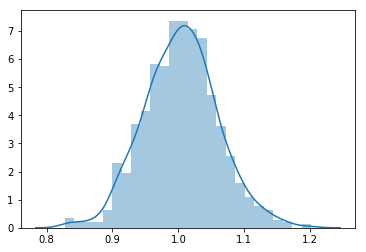

In [142]:
sns.distplot(result[1])